# Section 1: Dataset Selection & Cleaning

In [ ]:
from google.colab import drive
import pandas as pd
import json

# Mount Google Drive
drive.mount('/content/drive')

# Load the dataset
file_path = '/content/drive/My Drive/MKA_Advance_NLP/1st_Assignment/IndoNewsCorpus_Dataset/november.json'
with open(file_path, 'r') as f:
    data = json.load(f)

# Convert JSON to DataFrame
df = pd.DataFrame(data)
print(df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
           sumber     tanggal        kategori  \
0  tribunnews.com  2015/11/01  Bisnis Ekonomi   
1  tribunnews.com  2015/11/01  Bisnis Ekonomi   
2  tribunnews.com  2015/11/01  Bisnis Ekonomi   
3  tribunnews.com  2015/11/01  Bisnis Ekonomi   
4  tribunnews.com  2015/11/01  Bisnis Ekonomi   

                                               judul  \
0  Anggota DPR: Kenapa BUMN Diberi Subsidi Rakyat...   
1  DPR Bingung Anggaran Subsidi Listrik Rp 38 Tri...   
2  Jatah Subsidi Listrik Berkurang Picu Kecemburu...   
3  Migrasi Penggunaan Daya Listrik Dinilai Bisa B...   
4  Citi Indonesia Merevolusi Pengalaman Perbankan...   

                                                 isi  \
0  TRIBUNNEWS.COM, JAKARTA - Anggota Komisi VII D...   
1  TRIBUNNEWS.COM, JAKARTA - Anggota Komisi VII D...   
2  TRIBUNNEWS.COM, JAKARTA - Pengamat Ekonomi dar...   
3  TRIBUNNEWS.C

In [ ]:
import re
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')
nltk.download('stopwords')

indonesian_stopwords = set(stopwords.words('indonesian'))

def preprocess_text(text):
    text = text.lower()

    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)      # Remove numbers

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in indonesian_stopwords]

    return ' '.join(tokens)

# Apply preprocessing to the 'isi' column (article content)
df['cleaned_isi'] = df['isi'].apply(preprocess_text)

# Split into training (70%), validation (10%), and test (20%) sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['cleaned_isi'], df['kategori'], test_size=0.3, random_state=42)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=2/3, random_state=42)  # Split remaining 30% into 10% and 20%

print(f"Training set size: {len(train_texts)}")
print(f"Validation set size: {len(val_texts)}")
print(f"Test set size: {len(test_texts)}")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Training set size: 16934
Validation set size: 2419
Test set size: 4839


# Section 2: Methods

## 2.2 LSTM + IndoBERT


1. Install Required Libraries

In [ ]:
!pip install flair tensorflow==2.12 --quiet

2. Generate IndoBERT Embeddings

In [ ]:
from flair.embeddings import TransformerDocumentEmbeddings
from flair.data import Sentence
import numpy as np
import torch

torch.set_default_tensor_type('torch.FloatTensor')

indobert_embedding = TransformerDocumentEmbeddings(
    'indobenchmark/indobert-base-p2',
    allow_long_sentences=False  # Disable overlapping windows
)

def generate_flair_embeddings_in_batches(texts, max_len=128, batch_size=32):
    """
    Generate embeddings using Flair in batches with a maximum token length.
    """
    all_embeddings = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]
        sentences = []

        # Preprocess each text in the batch
        for text in batch_texts:
            text = " ".join(text.split()[:max_len])
            sentences.append(Sentence(text, use_tokenizer=True))
        indobert_embedding.embed(sentences)

        for sentence in sentences:
            all_embeddings.append(sentence.get_embedding().cpu().numpy())

    return np.array(all_embeddings)

X_train_flair = generate_flair_embeddings_in_batches(train_texts, max_len=128, batch_size=32)
X_val_flair = generate_flair_embeddings_in_batches(val_texts, max_len=128, batch_size=32)
X_test_flair = generate_flair_embeddings_in_batches(test_texts, max_len=128, batch_size=32)

print(f"Train embeddings shape: {X_train_flair.shape}")
print(f"Validation embeddings shape: {X_val_flair.shape}")
print(f"Test embeddings shape: {X_test_flair.shape}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Train embeddings shape: (16934, 768)
Validation embeddings shape: (2419, 768)
Test embeddings shape: (4839, 768)


3. Build and Compile the LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input

X_train_flair = X_train_flair.reshape(X_train_flair.shape[0], 1, X_train_flair.shape[1])

model = Sequential([
    Input(shape=(X_train_flair.shape[1], X_train_flair.shape[2])),
    LSTM(128, return_sequences=True, recurrent_activation='sigmoid'),
    Dropout(0.5),
    LSTM(64, return_sequences=False, recurrent_activation='sigmoid'),
    Dropout(0.5),
    Dense(len(set(train_labels)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 128)            459264    
                                                                 
 dropout_2 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
Total params: 509,192
Trainable params: 509,192
Non-trainable params: 0
_________________________________________________________________
None


4. Train the Model

In [ ]:
import tensorflow as tf

print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Device Name:", tf.test.gpu_device_name())


TensorFlow Version: 2.12.0
Num GPUs Available: 0
GPU Device Name: 


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

X_val_flair = X_val_flair.reshape(X_val_flair.shape[0], 1, X_val_flair.shape[1])
X_test_flair = X_test_flair.reshape(X_test_flair.shape[0], 1, X_test_flair.shape[1])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

with tf.device('/device:GPU:0'):
    lstm_IndoBERT = model.fit(
        X_train_flair,
        train_labels_encoded,
        validation_data=(X_val_flair, val_labels_encoded),
        epochs=10,
        batch_size=32,
        callbacks=[early_stopping]
    )

print(lstm_IndoBERT.history)

Epoch 1/10
530/530 [==============================] - 8s 8ms/step - loss: 0.6999 - accuracy: 0.7703 - val_loss: 0.3658 - val_accuracy: 0.8739
Epoch 2/10
530/530 [==============================] - 3s 6ms/step - loss: 0.4272 - accuracy: 0.8602 - val_loss: 0.3475 - val_accuracy: 0.8648
Epoch 3/10
530/530 [==============================] - 3s 6ms/step - loss: 0.3773 - accuracy: 0.8727 - val_loss: 0.3560 - val_accuracy: 0.8685
Epoch 4/10
530/530 [==============================] - 3s 6ms/step - loss: 0.3541 - accuracy: 0.8810 - val_loss: 0.3040 - val_accuracy: 0.8921
Epoch 5/10
530/530 [==============================] - 3s 6ms/step - loss: 0.3470 - accuracy: 0.8829 - val_loss: 0.3016 - val_accuracy: 0.8900
Epoch 6/10
530/530 [==============================] - 3s 6ms/step - loss: 0.3283 - accuracy: 0.8897 - val_loss: 0.2820 - val_accuracy: 0.8979
Epoch 7/10
530/530 [==============================] - 3s 6ms/step - loss: 0.3261 - accuracy: 0.8872 - val_loss: 0.2794 - val_accuracy: 0.9016
Epoch 

5. Evaluate the Model on the Test Set

152/152 [==============================] - 1s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.76      0.82       773
           1       0.98      0.99      0.98       686
           2       0.79      0.77      0.78       196
           3       0.91      0.96      0.94      2371
           4       0.93      0.91      0.92       274
           5       0.91      0.93      0.92       154
           6       0.93      0.86      0.90       236
           7       0.88      0.83      0.86       149

    accuracy                           0.91      4839
   macro avg       0.90      0.88      0.89      4839
weighted avg       0.91      0.91      0.91      4839



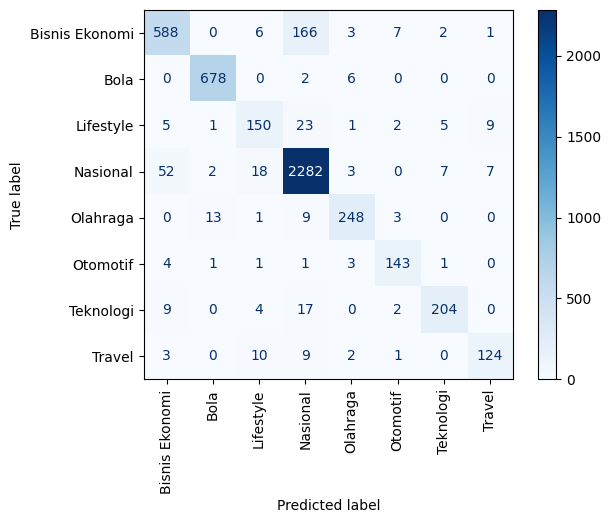

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

test_predictions = model.predict(X_test_flair).argmax(axis=1)

print("Classification Report:")
print(classification_report(test_labels_encoded, test_predictions))

conf_matrix = confusion_matrix(test_labels_encoded, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", xticks_rotation='vertical')